# Inflation Forecasting
> **Description:** Islamic Republic of Iran inflation forecasting with time series analysis
>
> **Authors:** Fatemeh Sadat Mousavi, Mahta Fetrat
>
> **Affiliation:** Students of Sharif University of Technology
>
> **Date:** Summer 1401

In [ ]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import math

# Load Data
The datasets are publicly available in [this](https://drive.google.com/drive/folders/1u6FyVqBlF7_meVR33mXUhpzp2SNPR5Xg?usp=sharing) folder with the id used below.

In [ ]:
!gdown --folder 1u6FyVqBlF7_meVR33mXUhpzp2SNPR5Xg &> /dev/null

In [ ]:
!ls ./datasets

annual_cpi   cpi_factors    gdp        monthly_cpi
cpi_changes  exchange_rate  liquidity  seasonal_mxp


In [ ]:
seasonal_mxp_df = pd.read_csv("datasets/seasonal_mxp/seasonal_mxp.csv")
liquidity_df = pd.read_csv("datasets/liquidity/liquidity.csv")
gdp_df = pd.read_csv("datasets/gdp/gdp.csv")
exchange_rate_df = pd.read_csv("datasets/exchange_rate/exchange_rate.csv")
monthly_cpi_df = pd.read_csv("datasets/monthly_cpi/monthly_cpi.csv")
annual_cpi_df = pd.read_csv("datasets/annual_cpi/annual_cpi.csv")

# Datasets Summary
*   **Seasonal MXP** Seasonal, 1391-1400
*   **Liquidity** Annual, 1344-1400
*   **GDP** Annual, 1341-1400
*   **Exchange Rate** Monthly, 01/1371-05/1401
*   **Monthly CPI** Monthly, 01/1361-04/1401
*   **Annual CPI** Annual, 1315-1400 


In [ ]:
seasonal_mxp_df.head(3)

,season,MXP
0,1/1/1391,25.7
1,4/1/1391,28.1
2,7/1/1391,32.5


In [ ]:
liquidity_df.head(3)

,year,liquidity
0,1344,105.6
1,1345,120.8
2,1346,144.3


In [ ]:
gdp_df.head(3)

,year,GDP,GDP growth
0,1341,1165380,10.25
1,1342,1263310,8.40
2,1343,1404074,11.14


In [ ]:
exchange_rate_df.head(3)

,date,USD
0,01/01/1371,1439.000000
1,02/01/1371,1447.880000
2,03/01/1371,1440.043478


In [ ]:
monthly_cpi_df.head(3)

,date,monthly CPI
0,1/1/1361,0.3
1,2/1/1361,0.2
2,3/1/1361,0.2


In [ ]:
annual_cpi_df.head(3)

,year,annual CPI
0,1315,0.0041
1,1316,0.0041
2,1317,0.0041


# Datesets Plot

In [ ]:
def plot_time_series(y, x, title, ylabel, xlabel, ax=None, step=1, c='b'):
  if not ax:
    fig, ax = plt.subplots(1, figsize=(18, 4))

  lenght = len(y)
  ax.plot(np.arange(lenght), y, c=c)
  ax.set_xticks(np.arange(lenght, step=step))
  ax.set_xticklabels(map(str, x.take(np.arange(lenght, step=step))), rotation=60)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)

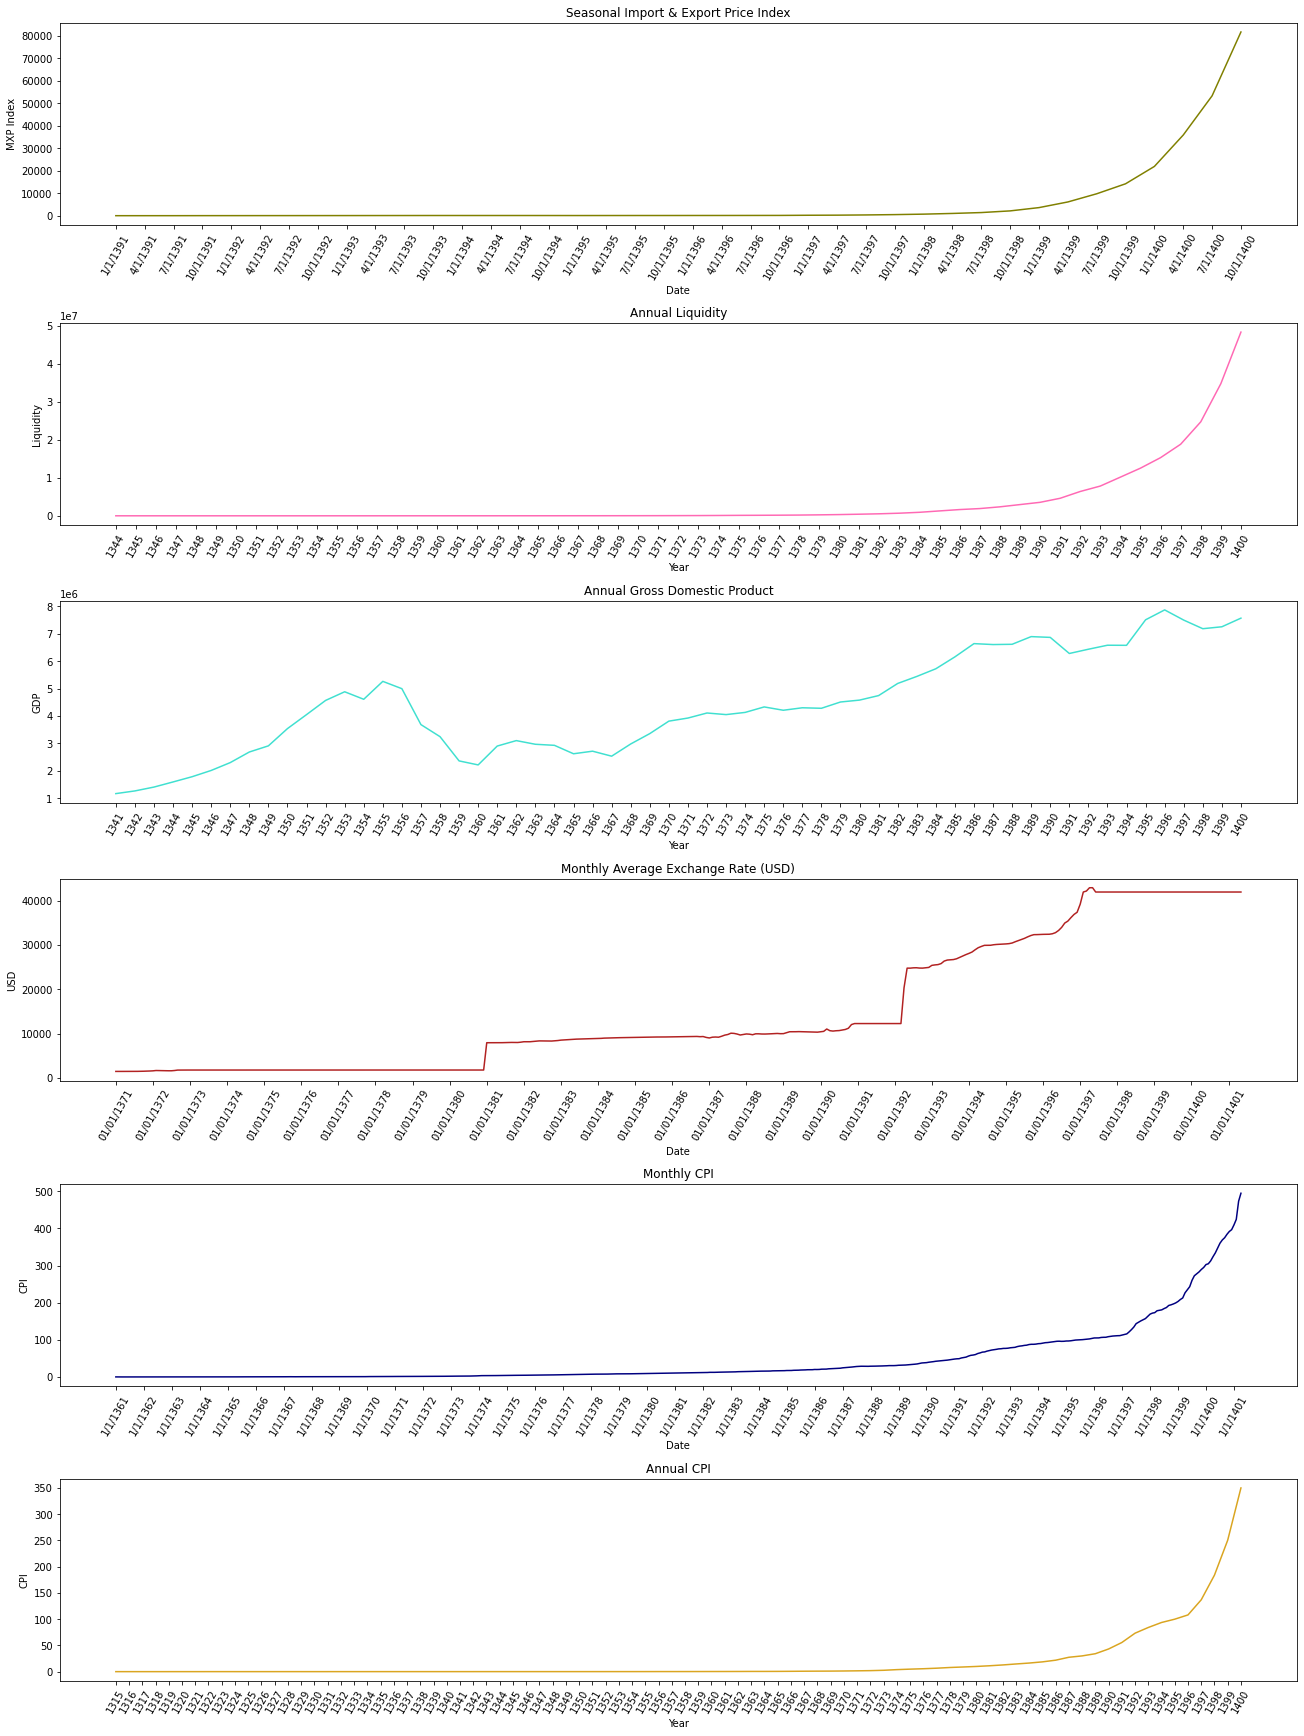

In [ ]:
fig, axs = plt.subplots(6, 1, figsize=(18, 24), constrained_layout=True)

# MXP 
plot_time_series(
    seasonal_mxp_df["MXP"],
    seasonal_mxp_df["season"],
    "Seasonal Import & Export Price Index",
    "MXP Index",
    "Date",
    ax=axs[0],
    c='olive',
)

# Liquidity
plot_time_series(
    liquidity_df["liquidity"],
    liquidity_df["year"],
    "Annual Liquidity",
    "Liquidity",
    "Year",
    ax=axs[1],
    c='hotpink',
)

# GDP 
plot_time_series(
    gdp_df["GDP"],
    gdp_df["year"],
    "Annual Gross Domestic Product",
    "GDP",
    "Year",
    ax=axs[2],
    c='turquoise'
)

# Exchange Rate 
plot_time_series(
    exchange_rate_df["USD"],
    exchange_rate_df["date"],
    "Monthly Average Exchange Rate (USD)",
    "USD",
    "Date",
    ax=axs[3],
    step=12,
    c='firebrick',
)

# Monthly CPI
plot_time_series(
    monthly_cpi_df["monthly CPI"],
    monthly_cpi_df["date"],
    "Monthly CPI",
    "CPI",
    "Date",
    ax=axs[4],
    step=12,
    c='navy',
)

# Annual CPI
plot_time_series(
    annual_cpi_df["annual CPI"],
    annual_cpi_df["year"],
    "Annual CPI",
    "CPI",
    "Year",
    ax=axs[5],
    c='goldenrod',
)

# Box-Jenkins method 
In time series analysis, the Box–Jenkins method, named after the statisticians George Box and Gwilym Jenkins, applies autoregressive moving average (ARMA) or autoregressive integrated moving average (ARIMA) models to find the best fit of a time-series model to past values of a time series.

The method comprises three steps. Below contains an explanation of how each step is performed in our implementation.

* **Model identification and model selection:** making sure that the variables are stationary, identifying seasonality in the dependent series, and using plots of the autocorrelation (ACF) and partial autocorrelation (PACF) functions of the dependent time series to decide which (if any) autoregressive or moving average component should be used in the model.
* **Parameter estimation:** using computation algorithms to arrive at coefficients that best fit the selected ARIMA model. This step is done behind the scenes at a call to the `fit` function of the models.
* **Statistical model checking:** by testing whether the estimated model conforms to the specifications of a stationary univariate process. In particular, the residuals should be independent of each other and constant in mean and variance over time. (Plotting the mean and variance of residuals over time and performing a Ljung–Box test or plotting autocorrelation and partial autocorrelation of the residuals are helpful to identify misspecification.) If the estimation is inadequate, we have to return to step one and attempt to build a better model.

Passing all these three steps, the model can be used to make forecasts on the future, unseen time steps.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method#Box%E2%80%93Jenkins_model_diagnostics)

# ARIMA Model
In this section we will provide some utility functions to build a proper ARIMA model based on the Box-Jenkins method steps. These functions will be used on each dataset separately in the next section.

In [ ]:
# Stationarity test
from statsmodels.tsa.stattools import adfuller

# Autocorrelation and partial autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# The ARIMA model
from statsmodels.tsa.arima.model import ARIMA

import warnings
from statsmodels.tools.sm_exceptions import *
warnings.simplefilter('ignore', UserWarning)

In [ ]:
!pip3 install pmdarima &> /dev/null

In [ ]:
import pmdarima as pm

## Stationarity
The statistical models used for time series analysis is this study, assume the dataset to be stationary. We will use the ADF test to check the stationarity of the datasets and the difference transform to make dataset stationary if needed.

### Augmented Dickey-Fuller Test (ADF)
> The null hypothesis of the ADF test assumes the presence of a unit root, the p-value obtained by the test should be less than the significance level (say 0.05) to reject the null hypothesis. Thereby, inferring that the series is stationary. - [analyticsindiamag](https://analyticsindiamag.com/)

The adfuller test provides the test statistics, the p-value, and the critical values as output. So in order to state that the dataset is stationary (rejecting the null hypothesis), we can either check if p-value < 0.05 or if the test statistics < critical value of the interested confidence level (5% in our case).

In [ ]:
def adf_stationarity_test(series):
  result = adfuller(series.values)

  print(f'ADF Statistic: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Critical Values:')
  for key, value in result[4].items():
      print(f'\t{key}: {value:.3f}')

  stationary = (result[1] <= 0.05) & (result[4]['5%'] > result[0])
  color_format = "\033[92m{}\033[0m\n\n" if stationary else "\033[91m{}\033[0m\n\n"
  print(color_format.format("Stationary" if stationary else "Non-stationary"))

  return stationary

### Difference Transform
An important thing to note while applying the difference transform is over-differencing and under-differencing. In case of over-differencing, the time-series would yield limited useful information. Forecasting would be simplified to the naive forecast.

**How to identify over/under-differencing?**
> Rule 1: If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.
>
> Rule 2: If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of  differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.  BEWARE OF OVERDIFFERENCING!!
>
> Rule 3: The optimal order of differencing is often the order of differencing at which the standard deviation is lowest. - [Source](https://people.duke.edu/~rnau/411arim2.htm)


**What to do in case over/under-differencing unavoidable?**
> If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, try adding an additional MA term. - [machinelearningplus](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)


In [ ]:
def apply_diff(y, d=1):
  for i in range(d):
    y = y.diff().fillna(0)
  return y

In [ ]:
def show_differencing_results(y, x, title, ylabel, xlabel, order):
  fig, axs = plt.subplots(1, 2, figsize=(20, 2.5))
  plot_time_series(
      y,
      x,
      f"Order {order} Differenced {title}",
      f"Differenced {ylabel}",
      xlabel,
      ax=axs[0],
      step=-1
  )
  plot_acf(y, lags=10, ax=axs[1])
  plt.show()

  print(f"Std of the differenced series: {np.std(y)}")

In [ ]:
def check_stationarity(y, x, title, ylabel, xlabel):
  for i in range(11):
    show_differencing_results(y, x, title, ylabel, xlabel, i)
    if adf_stationarity_test(y):
      print(f"The dataset is staionary with differencing order {i}.")
      return
  
    y = apply_diff(y)

  print(f"The dataset is not staionary even with tenth order differencing.")

## Parameter Selection (p, q)
Having ensured the data stationarity, we should then choose some proper values for the p and q parameters of the ARIMA model. We will use a combination of three approaches for this purpose.

### ACF/PACF plots
We will use the autocorrelation and partial autocorrelation function plots (ACF and PACF respectively) to help visually find good choices for p and q parameters of the ARIMA model.

The p parameter can be chosen from the lags which show a strong partial autocorrelation. Simillarly, q can be chosen from the autocorrelation plot. If any of the ACF and PACF values show no significant lag, their corresponding parameter will be set to 0 and hence the model will be pure AR or MA.

In [ ]:
def plot_acf_pacf(series, lags=10):
  fig, axs = plt.subplots(1, 2, figsize=(20, 4))

  plot_acf(series,lags=lags, ax=axs[0])
  plot_pacf(series,lags=lags, ax=axs[1], method="ywm")
      
  plt.show()

### Auto Arima
Another utility that can help selecting a parameter set is the pmdarima library which lookes throug possible combination of parameters with regrad to its configurations and returns the one with the least AIC score.

By the way, this tool is not that reliable to be delegated the responsibility of selecting the final model and we will use it only as a suggestion tool.

In [ ]:
def apply_auto_arima_model_selection(series, stepwise=True):
    model = pm.auto_arima(
        series,
        start_p=0,
        start_q=0,
        max_p=10,
        max_q=10,
        max_d=10,
        seasonal=False,
        trace=True,
        test='adf',
        error_action='ignore',  # don't want to know if an order does not work
        suppress_warnings=True,  # don't want convergence warnings
        stepwise=stepwise,
    )

    fig, ax = plt.subplots(figsize=(15,4))
    plt.plot(series, label="Actual")
    plt.plot(model.predict_in_sample()[1:], label="Predicted")
    plt.legend()
    plt.show()

### AIC measure
After plotting the acf/pacf plots and outputting the selection of the auto arima tool, we will suggest some models that would probably perform best and use the AIC measure to select the best model from the suggestions as the final one.

In [ ]:
def select_and_fit_best_model(series, orders):
    best_model = None
    min_aic = math.inf

    for order in orders:
      model = ARIMA(series, order=order).fit()
      if model.aic < min_aic:
        best_model = model
    
    print(model.summary())
    return best_model

## Model Checking
Here we will provide both visual and statistical test results to show that the model passes the Box-Jenkins requirements and hence is able to produce reliable results in the forecasing pahse. 

### Plot Predictions
One of the simplest yer most important checks to be done is to see if the model fits the training data well by plotting in-sample predictions. Taking a look at the future forecasts of the model can help as well.

In [ ]:
def plot_predictions(fitted_model, actual_series, num_of_forecasts=5, alpha=0.05):
  conf = fitted_model.get_forecast(num_of_forecasts).conf_int(alpha=alpha)
  lenght = len(actual_series)
  predictions = fitted_model.predict(1, lenght + num_of_forecasts - 1)

  forecast_index = np.arange(lenght, lenght + num_of_forecasts - 1)
  lower_series = pd.Series(conf.iloc[:, 0], index=forecast_index)
  upper_series = pd.Series(conf.iloc[:, 1], index=forecast_index)

  plt.figure(figsize=(18,5))
  plt.plot(actual_series, label='Actual')
  plt.plot(predictions, label='Predictions')
  plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
  plt.title('Predictions vs Actuals')
  plt.legend(loc="upper left")
  plt.show()

### Plot reiduals diagnostics
For the model to be accepted by the Box-Jenkins method, the residuals must be independent of each other and show no autocorrelation.
> The errors from an ideal model would resemble white noise, that is a Gaussian distribution with a mean of zero and a symmetrical variance.
> 
> Additionally, an ideal model would leave no temporal structure in the time series of forecast residuals. These can be checked by creating ACF and PACF plots of the residual error time series. - [machinelearningmastery](https://machinelearningmastery.com/gentle-introduction-box-jenkins-method-time-series-forecasting/)

So we will plot the AC and PAC functions as well as the KDE for the residuals.


In [ ]:
def plot_residuals_diagnostics(fitted_model):
  fig, axs = plt.subplots(1, 2, figsize=(18, 5))
  
  fitted_model.resid.plot(
      ax=axs[0],
      kind='kde',
      title='ARIMA Fit Residual Error Density Plot',
      xlabel='Residual Values',
      grid=True,
  )
  plot_acf(fitted_model.resid, lags=10, ax=axs[1])
  plt.show()

  print(f"Mean: {np.mean(fitted_model.resid)}")
  print(f"STD: {np.std(fitted_model.resid)}\n")

### Apply normality test for residuals
Although the plotting methods above help visualize how well the residuals fit the desired distribution, statistical tests can provide more reliable results and hence are also used in this study. As it was suggested in the Box-Jenkins method section in this notebook, we are going to use the **Ljung-Box** test, the null hypothsis of which is as follows: 

*   H0: The data are independently distributed.

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
def apply_normality_tests(fitted_model):
  pvalues = acorr_ljungbox(fitted_model.resid, lags= 10)['lb_pvalue'].to_numpy()

  print(f"Ljung-Box Test")
  print(f"p-values: {pvalues}")

  independent = np.all(pvalues >= 0.05)
  color_format = "\033[92m{}\033[0m\n\n" if independent else "\033[91m{}\033[0m\n\n"
  print(f"result: {color_format.format('Independent' if independent else 'Not Independent')}")

## Forecast
Once the model passes the diagnostics, its time to safely use it to forecast future time steps. The ARIMA model can be used to forecast as many time steps as needed but ofcourse there will be more confidence for the the closer forecasts in time.

In [ ]:
def plot_forecasts(fitted_model, training_series, steps=5):
    forecast_series = pd.Series(fitted_model.forecast(steps))

    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(training_series, label="Training Data")
    plt.plot(forecast_series, label="Forecasts")
    plt.title(f"Forcasted Values for Unseen Time Steps")
    plt.legend()
    plt.show()

In [ ]:
def get_forecasts(fitted_model, time_steps=1):
  return fitted_model.forecast(time_steps)

# Time Series Analysis
In this section we will use the utility functions from the previous section to buid proper ARIMA models for each of the datasets based on the Box_Jenkins method and use the results to forecast values in the time steps of interest in this study.

Just one more step before jumping to the datasets, let's implement two helper functions. One to select the model with the least aic from a list of suggested models and the other to show the diagnostics of a selected model.  

In [ ]:
def check_models(series, orders):
  for idx, order in enumerate(orders):
    fitted_model = ARIMA(series, order=order).fit()

    print(f"ARIMA{fitted_model.specification.order}", end="\t\t\t:")
    print(f"AIC={round(fitted_model.aic, 3)}, BIC={round(fitted_model.bic, 3)}, MAE={round(fitted_model.mae, 3)}")

In [ ]:
def show_model_diagnostics(series, fitted_model, forecasts=5):
  plot_predictions(fitted_model, series, num_of_forecasts=forecasts)
  print(f"\n{'='*50}Residuals{'='*100}\n")
  plot_residuals_diagnostics(fitted_model)
  apply_normality_tests(fitted_model)

## Seasonal MXP Analysis

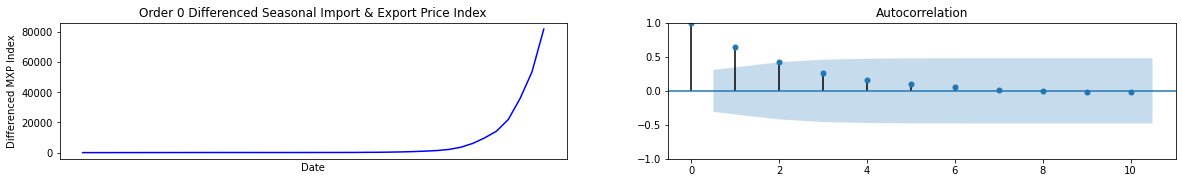

Std of the differenced series: 16033.55627854828
ADF Statistic: 2.976149398820866
p-value: 1.0
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623
Non-stationary




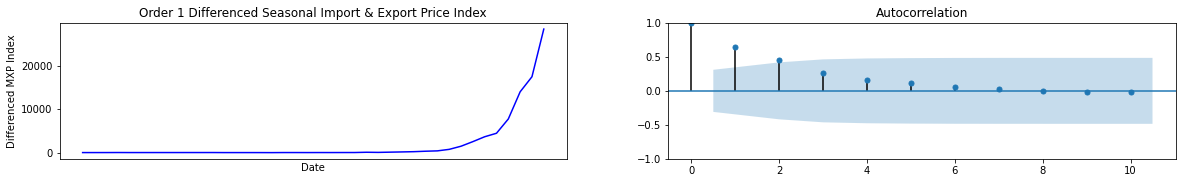

Std of the differenced series: 5572.318172670599
ADF Statistic: 1.7852422991168606
p-value: 0.9983192939951184
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623
Non-stationary




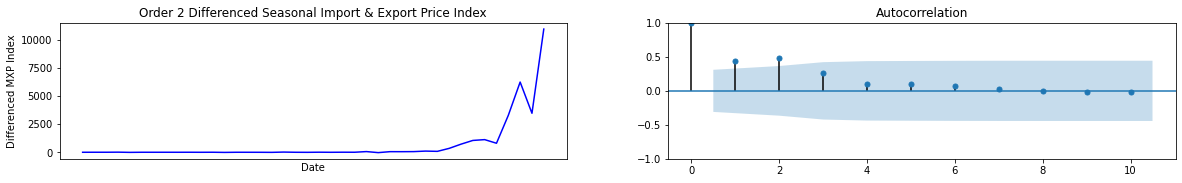

Std of the differenced series: 2034.455380438152
ADF Statistic: 4.914704324657332
p-value: 1.0
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623
Non-stationary




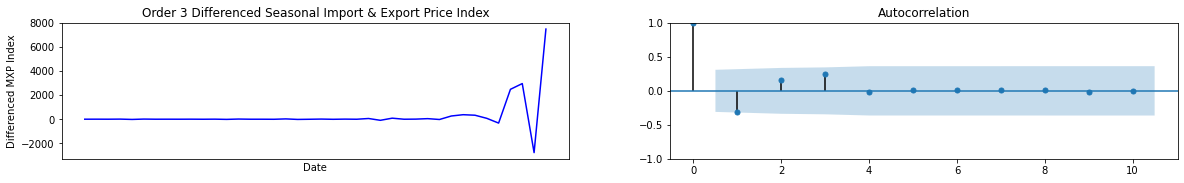

Std of the differenced series: 1380.4198313918816
ADF Statistic: 5.869423203265453
p-value: 1.0
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623
Non-stationary




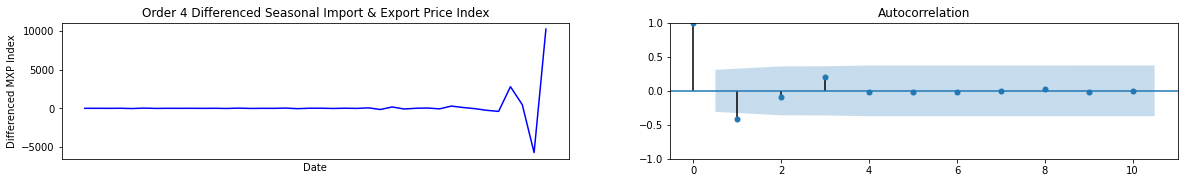

Std of the differenced series: 1907.1342516308937
ADF Statistic: 4.0157862363025
p-value: 1.0
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623
Non-stationary




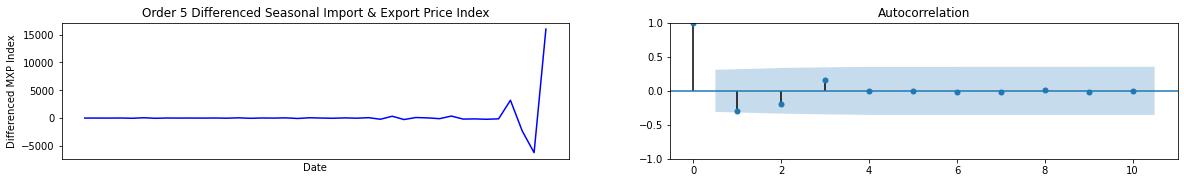

Std of the differenced series: 2776.9262964190643
ADF Statistic: 2.6546389561183386
p-value: 0.9990832737559108
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623
Non-stationary




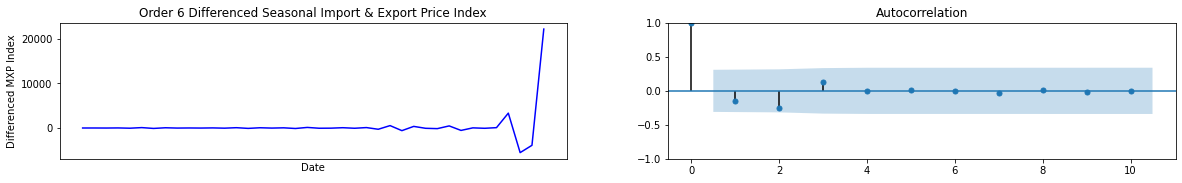

Std of the differenced series: 3693.9768784121607
ADF Statistic: -0.6284071976467891
p-value: 0.8644331136781072
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619
Non-stationary




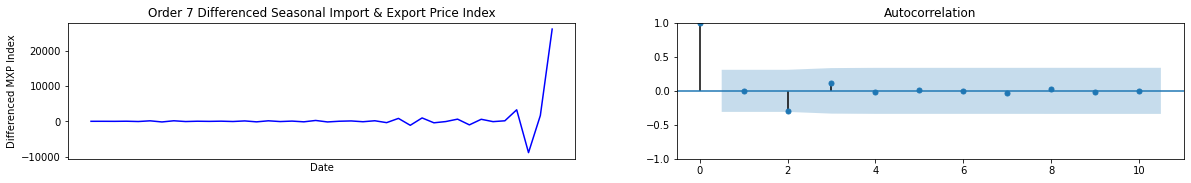

Std of the differenced series: 4377.851319339613
ADF Statistic: -10.854340320055226
p-value: 1.500883284303383e-19
Critical Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618
Stationary


The dataset is staionary with differencing order 7.


In [ ]:
check_stationarity(
    seasonal_mxp_df["MXP"],
    seasonal_mxp_df["season"],
    "Seasonal Import & Export Price Index",
    "MXP Index",
    "Date",
)

From the stationarity check, d can be 2 or 3. The third order difference has a less std and hence is preferred. d=2 seems to be an under-differencing and d=3 is an over-differencing. So note that a bigger choice of p would help recover from the over-differencing at d=3 and a choice of bigger q would help overcome under-differencing at d=2. Now in order to choose q and p, let's plot the ACF and PACF to get some insight.

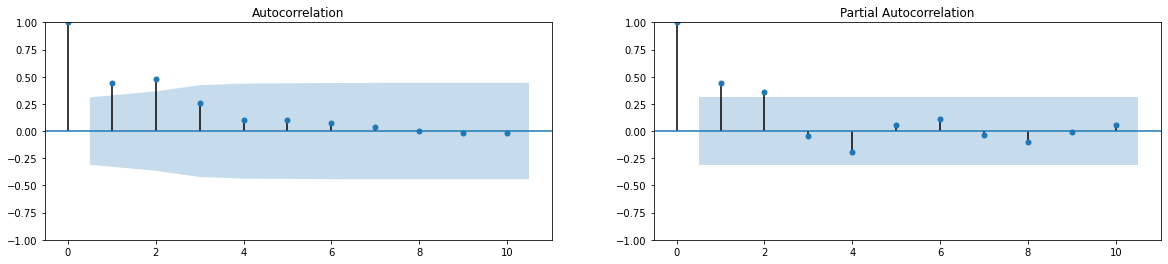

In [ ]:
plot_acf_pacf(apply_diff(seasonal_mxp_df["MXP"], d=2), lags=10)

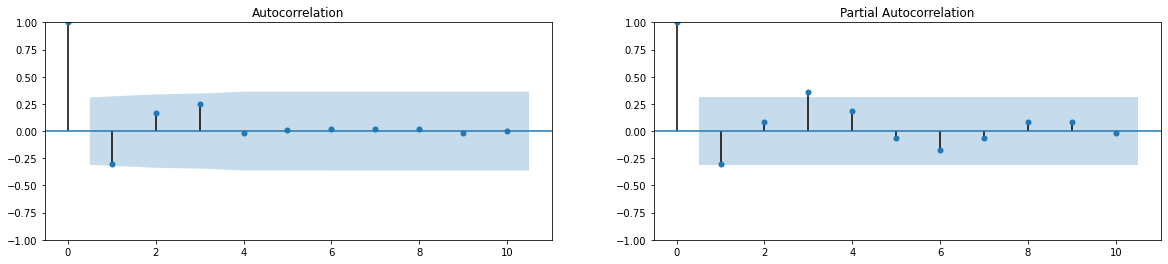

In [ ]:
plot_acf_pacf(apply_diff(seasonal_mxp_df["MXP"], d=3), lags=10)

According to the plots above we got these choices:
* d=2 with q=1 or 2 and p=1 or 2
* d=3 with q=0 and p=3

Now let's take a look at the auto_arima models' selection to see if we got other choices.

 ARIMA(0,5,0)(0,0,0)[0]             : AIC=661.339, Time=0.05 sec
 ARIMA(0,5,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,5,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,5,3)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(0,5,4)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(0,5,5)(0,0,0)[0]             : AIC=inf, Time=0.85 sec
 ARIMA(1,5,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,5,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,5,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(1,5,3)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(1,5,4)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(2,5,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,5,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,5,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(2,5,3)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(3,5,0)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(3,5,1)(0,0,0)

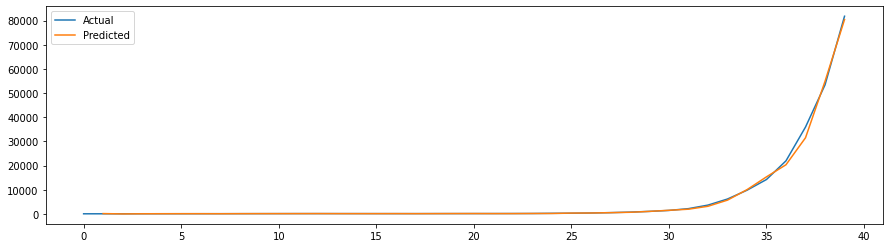

In [ ]:
apply_auto_arima_model_selection(seasonal_mxp_df["MXP"], stepwise=False)

Now its time to provide the list of out guesses for a good model and select the best of them based on both the AIC score and MAE measure.

In [ ]:
best_model = check_models(
    seasonal_mxp_df["MXP"], 
    [
        (3, 5, 1), (3, 2, 1), (3, 3, 1),
        (1, 2, 2), (2, 2, 2),
        (1, 2, 1), (2, 2, 1),
        (3, 3, 0),
        (0, 2, 3),
     ]
)

ARIMA(3, 5, 1)			:AIC=587.109, BIC=594.886, MAE=300.368
ARIMA(3, 2, 1)			:AIC=10.0, BIC=18.188, MAE=58680.239
ARIMA(3, 3, 1)			:AIC=10.0, BIC=18.055, MAE=5888.825
ARIMA(1, 2, 2)			:AIC=642.748, BIC=649.298, MAE=328.477
ARIMA(2, 2, 2)			:AIC=644.624, BIC=652.812, MAE=329.623
ARIMA(1, 2, 1)			:AIC=663.041, BIC=667.953, MAE=422.181
ARIMA(2, 2, 1)			:AIC=8.0, BIC=14.55, MAE=5888.825
ARIMA(3, 3, 0)			:AIC=631.687, BIC=638.13, MAE=328.861
ARIMA(0, 2, 3)			:AIC=664.053, BIC=670.604, MAE=406.139


Discarding the model with AIC=8 which shows a drastic MAE, the best model is (3, 5, 1)

In [ ]:
seasonal_mxp_model = ARIMA(seasonal_mxp_df["MXP"], order=(3, 5, 1)).fit()

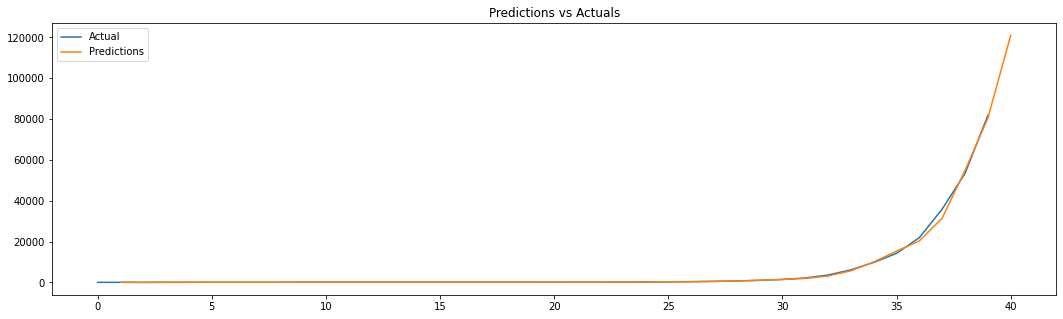


==================================================Residuals====================================================================================================



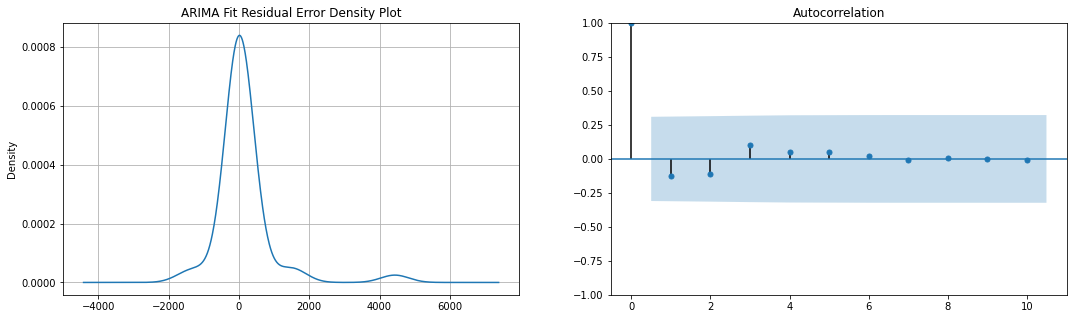

Mean: 146.04610425183017
STD: 826.1456416993753

Ljung-Box Test
p-values: [0.41973629 0.557931   0.65701916 0.78579166 0.86900318 0.93106326
 0.96633501 0.98440567 0.99318998 0.9971443 ]
result: Independent




In [ ]:
show_model_diagnostics(seasonal_mxp_df["MXP"], seasonal_mxp_model, forecasts=1)

Now let's see the foracasts this model makes.

In [ ]:
seasonal_mxp_df.tail(3)

,season,MXP
37,4/1/1400,35931.7
38,7/1/1400,53381.0
39,10/1/1400,81791.9


In [ ]:
print(f"The MXP forecast for 1/1/1401 is: {seasonal_mxp_model.forecast().to_numpy()[0]}")

The MXP forecast for 1/1/1401 is: 120965.0999091511


## Liquidity Analysis

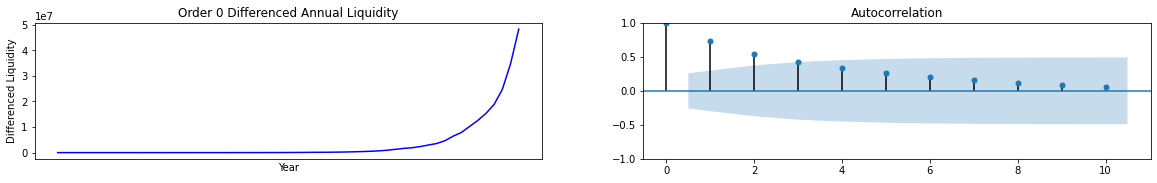

Std of the differenced series: 8839173.363828367
ADF Statistic: -2.561082368515287
p-value: 0.1013104333280076
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599
Non-stationary




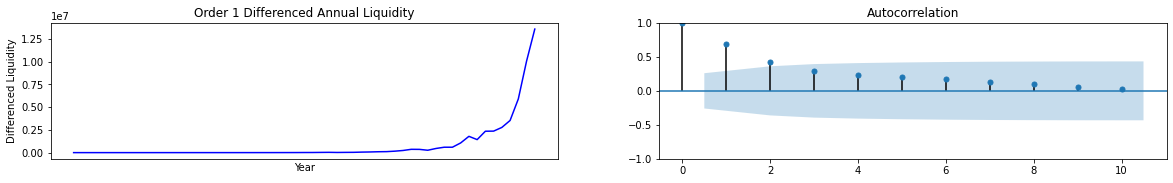

Std of the differenced series: 2359850.910036232
ADF Statistic: -3.631630014535533
p-value: 0.005184338611646054
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602
Stationary


The dataset is staionary with differencing order 1.


In [ ]:
check_stationarity(
    liquidity_df["liquidity"],
    liquidity_df["year"],
    "Annual Liquidity",
    "Liquidity",
    "Year",
)

As you can see from the stationarity check above, d=1 is a good choice.

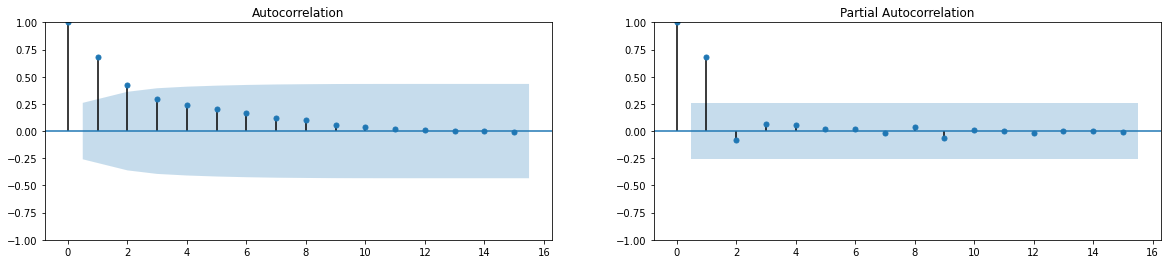

In [ ]:
plot_acf_pacf(apply_diff(liquidity_df["liquidity"], d=1), lags=15)

q=1 or 2 and p=1 seem perfect choices with first order differencing but we will try higher values for p since the dataset is still a little under-differenced (AC seems to have a hard time reaching zero) and higher orders of AR can make up for that.

 ARIMA(0,4,0)(0,0,0)[0]             : AIC=1570.348, Time=0.02 sec
 ARIMA(0,4,1)(0,0,0)[0]             : AIC=1535.356, Time=0.05 sec
 ARIMA(0,4,2)(0,0,0)[0]             : AIC=1536.926, Time=0.05 sec
 ARIMA(0,4,3)(0,0,0)[0]             : AIC=1538.898, Time=0.12 sec
 ARIMA(0,4,4)(0,0,0)[0]             : AIC=1537.289, Time=0.23 sec
 ARIMA(0,4,5)(0,0,0)[0]             : AIC=1546.247, Time=0.15 sec
 ARIMA(1,4,0)(0,0,0)[0]             : AIC=1547.628, Time=0.02 sec
 ARIMA(1,4,1)(0,0,0)[0]             : AIC=1534.346, Time=0.09 sec
 ARIMA(1,4,2)(0,0,0)[0]             : AIC=1536.089, Time=0.08 sec
 ARIMA(1,4,3)(0,0,0)[0]             : AIC=1538.965, Time=0.17 sec
 ARIMA(1,4,4)(0,0,0)[0]             : AIC=1538.410, Time=0.31 sec
 ARIMA(2,4,0)(0,0,0)[0]             : AIC=1538.395, Time=0.02 sec
 ARIMA(2,4,1)(0,0,0)[0]             : AIC=1536.161, Time=0.07 sec
 ARIMA(2,4,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(2,4,3)(0,0,0)[0]             : AIC=1534.054, Time=0.37 sec
 ARIMA(3,4,0)(0

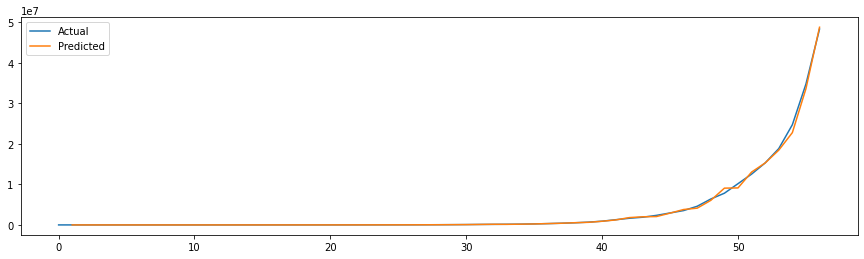

In [ ]:
apply_auto_arima_model_selection(liquidity_df["liquidity"], stepwise=False)

So we will test (2, 4, 3) for the parameters since it had the least AIC in the models auto_arima tested. Also we'll try a model that doesn't apply differencing. This way the autocorrelation of the data won't dissapear.

In [ ]:
check_models(
    liquidity_df["liquidity"],
    [
        (2, 4, 3), (2, 1, 3),
        (1, 1, 1), (1, 1, 2),
        (2, 1, 1), (2, 1, 2),
        (3, 1, 1), (3, 1, 2),
    ],
)

ARIMA(2, 4, 3)			:AIC=1534.054, BIC=1545.875, MAE=151343.628
ARIMA(2, 1, 3)			:AIC=1680.008, BIC=1692.16, MAE=158997.68
ARIMA(1, 1, 1)			:AIC=1689.322, BIC=1695.398, MAE=214427.2
ARIMA(1, 1, 2)			:AIC=1644.633, BIC=1652.734, MAE=192678.984
ARIMA(2, 1, 1)			:AIC=1627.26, BIC=1635.361, MAE=167366.408
ARIMA(2, 1, 2)			:AIC=1631.879, BIC=1642.005, MAE=166782.037
ARIMA(3, 1, 1)			:AIC=1628.666, BIC=1638.793, MAE=167212.847
ARIMA(3, 1, 2)			:AIC=1635.611, BIC=1647.763, MAE=164474.516


As you see, the best model both in terms of AIC and MAE is the (2, 4, 3) model.

In [ ]:
liquidity_model = ARIMA(liquidity_df["liquidity"], order=(2, 4, 3)).fit()

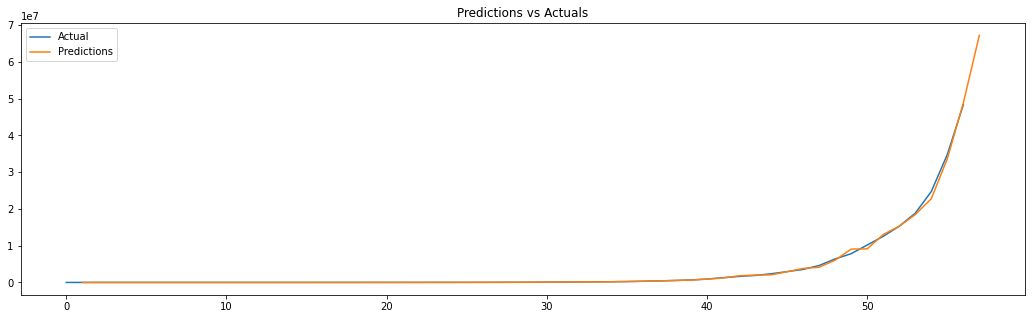


==================================================Residuals====================================================================================================



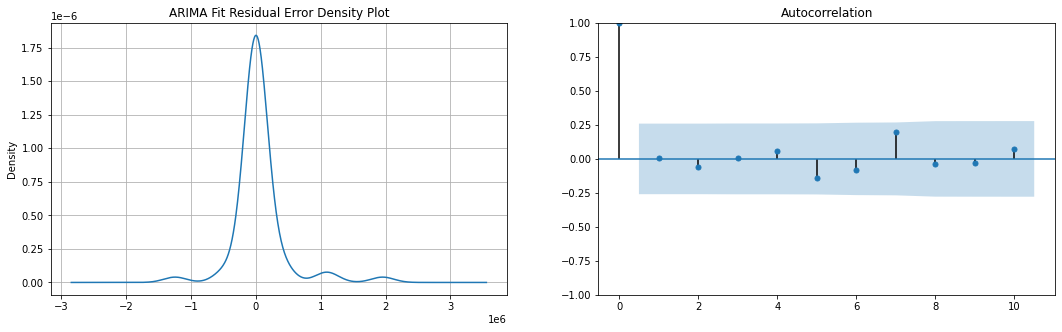

Mean: 53550.19990197515
STD: 391311.04902588355

Ljung-Box Test
p-values: [0.96799552 0.88810361 0.97114748 0.97716856 0.88837954 0.90448811
 0.68565157 0.76999712 0.83963831 0.87142948]
result: Independent




In [ ]:
show_model_diagnostics(liquidity_df["liquidity"], liquidity_model, forecasts=1)

Now let's see the foracasts this model makes.

In [ ]:
liquidity_df.tail(3)

,year,liquidity
54,1398,24721500.0
55,1399,34761700.0
56,1400,48324400.0


In [ ]:
print(f"The liquidity forecast for 1401 is: {liquidity_model.forecast().to_numpy()[0]}")

The liquidity forecast for 1401 is: 67201584.60890095


## GDP Analysis

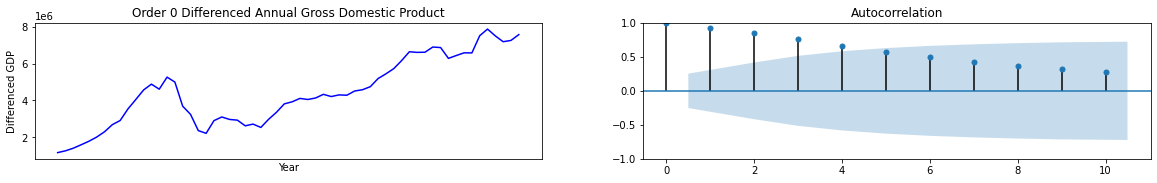

Std of the differenced series: 1836145.091997911
ADF Statistic: -0.6773905395481553
p-value: 0.8525193055897886
Critical Values:
	1%: -3.555
	5%: -2.916
	10%: -2.596
Non-stationary




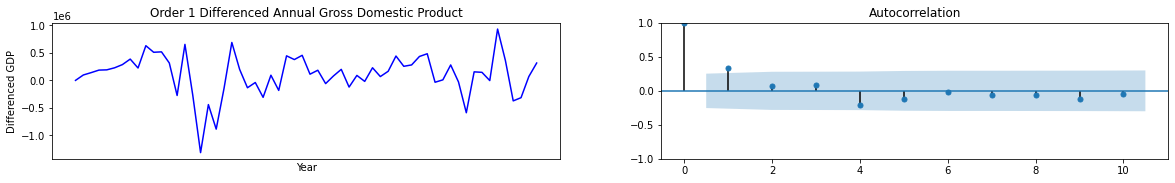

Std of the differenced series: 366566.03135706217
ADF Statistic: -4.19273994591916
p-value: 0.0006777955068244185
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
Stationary


The dataset is staionary with differencing order 1.


In [ ]:
check_stationarity(
    gdp_df["GDP"],
    gdp_df["year"],
    "Annual Gross Domestic Product",
    "GDP",
    "Year",
)

From the stationarity check, the choice of d=1 is obvious. Next we got to choose the p and q parameters. So let's plot the ACF and PACF to get some insight.

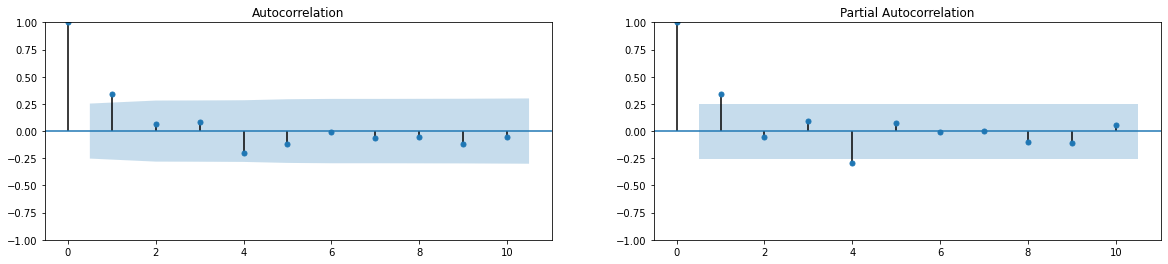

In [ ]:
plot_acf_pacf(apply_diff(gdp_df["GDP"], d=1), lags=10)

According to the plots above, the choice of q=1 seems proper. But for the p parameter, we might choose 1 or 4. Before that, let's take a look at the auto_arima models' selection.

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1684.150, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1679.407, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1681.463, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1681.206, Time=0.06 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1683.738, Time=0.09 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1683.680, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1679.806, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1680.876, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1683.009, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1682.868, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1684.050, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1681.702, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1682.166, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1683.626, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1677.854, Time=0.28 sec
 ARIMA(3,1

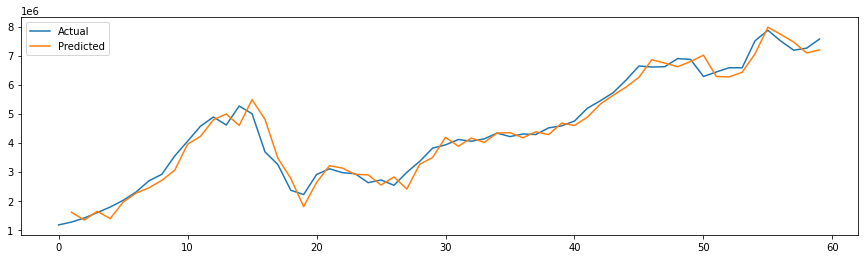

In [ ]:
apply_auto_arima_model_selection(gdp_df["GDP"], stepwise=False)

So we might as well want to test (2, 1, 3) for the parameters since it had the least AIC in the models auto_arima tested. Now its time to provide the list of out guesses for a good model and select the best of them based on both the AIC score and and MAE measure.

In [ ]:
check_models(gdp_df["GDP"], [(2, 1, 3), (1, 1, 1), (4, 1, 1)])

ARIMA(2, 1, 3)			:AIC=1677.175, BIC=1689.64, MAE=271736.629
ARIMA(1, 1, 1)			:AIC=1682.084, BIC=1688.316, MAE=282370.908
ARIMA(4, 1, 1)			:AIC=1683.489, BIC=1695.954, MAE=289757.555


As you see, the best model both in terms of AIC and MAE is the (2, 1, 3) model.

In [ ]:
gdp_model = ARIMA(gdp_df["GDP"], order=(2, 1, 3)).fit()

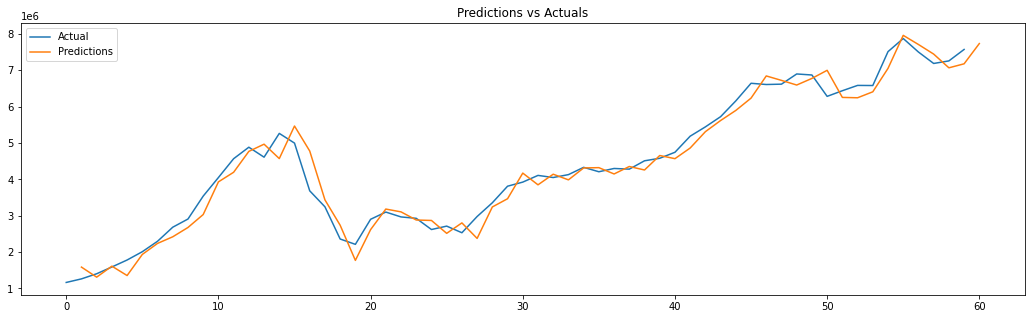


==================================================Residuals====================================================================================================



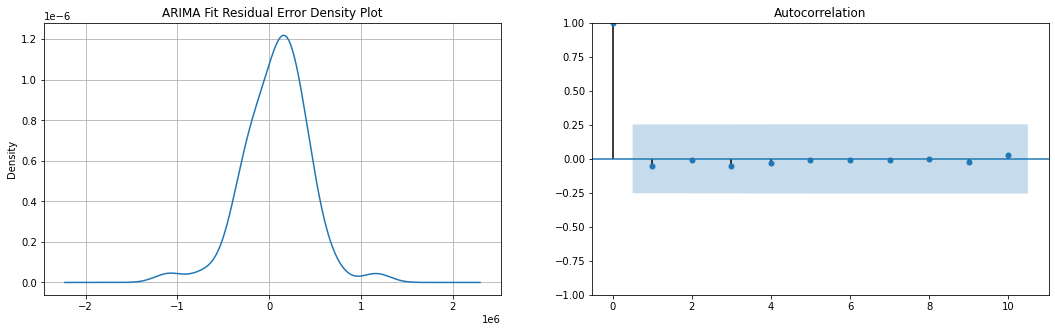

Mean: 78928.63029921337
STD: 343026.54804008844

Ljung-Box Test
p-values: [0.67285273 0.91251138 0.94306029 0.97825477 0.99379464 0.99828786
 0.99957428 0.99990132 0.99996857 0.99998662]
result: Independent




In [ ]:
show_model_diagnostics(gdp_df["GDP"], gdp_model, forecasts=1)

Now let's see the foracasts this model makes.

In [ ]:
gdp_df.tail(3)

,year,GDP,GDP growth
57,1398,7183703,-4.19
58,1399,7254000,0.98
59,1400,7569000,4.34


In [ ]:
print(f"The GDP forecast for 1401 is: {gdp_model.forecast().to_numpy()[0]}")

The GDP forecast for 1401 is: 7730842.359911759


## Exchange Rate Analysis

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result_mult = seasonal_decompose(exchange_rate_df["USD"].copy(), model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

TypeError: ignored

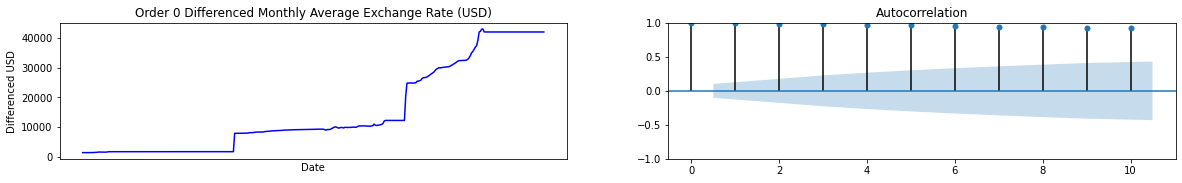

Std of the differenced series: 14481.388053902157
ADF Statistic: 0.7438889243188095
p-value: 0.9906742572671989
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Non-stationary




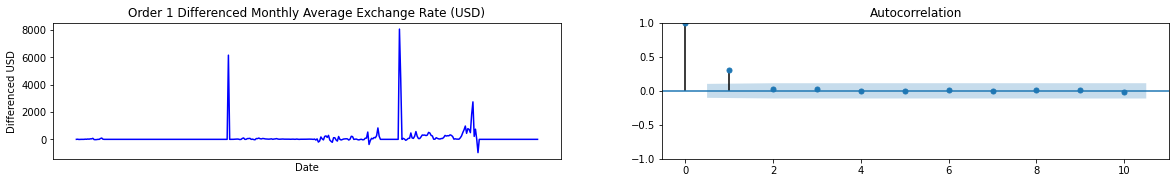

Std of the differenced series: 616.620925398474
ADF Statistic: -13.754493865557588
p-value: 1.035721742355193e-25
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
Stationary


The dataset is staionary with differencing order 1.


In [ ]:
check_stationarity(
    exchange_rate_df["USD"],
    exchange_rate_df["date"],
    "Monthly Average Exchange Rate (USD)",
    "USD",
    "Date",
)

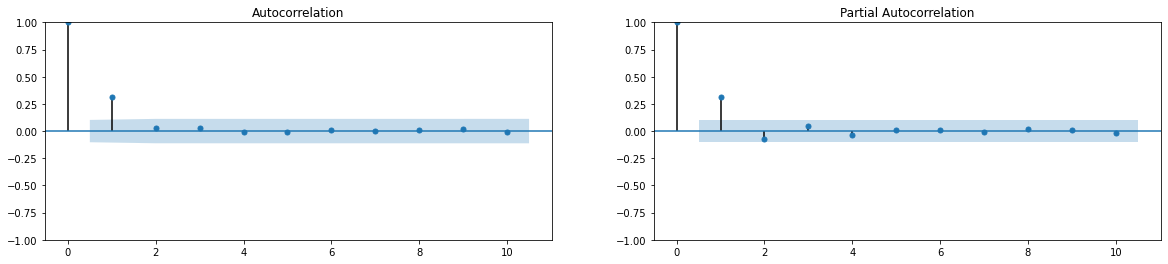

In [ ]:
plot_acf_pacf(apply_diff(exchange_rate_df["USD"], d=1), lags=10)

According to the plots above, the choice of q=1 and p=1 seem well. Before that, let's take a look at the auto_arima models' selection.

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5714.811, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5677.004, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5678.701, Time=0.58 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5680.667, Time=0.35 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=5682.773, Time=0.28 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=5684.175, Time=1.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5679.337, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5678.892, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5680.550, Time=0.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5682.333, Time=0.72 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=5684.459, Time=1.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5679.327, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5680.930, Time=1.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5682.236, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5684.136, Time=2.50 sec
 ARIMA(3,1

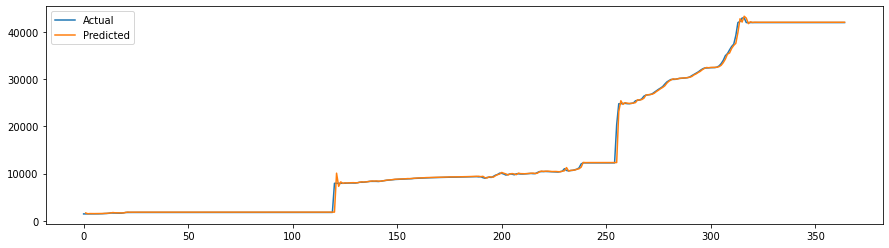

In [ ]:
apply_auto_arima_model_selection(exchange_rate_df["USD"], stepwise=False)

According to the output of auto arima model, (0, 1, 1) might be a good model. Now its time to provide the list of out guesses for a good model and select the best of them based on both the AIC score and MAE measure.

In [ ]:
check_models(exchange_rate_df["USD"], [(0, 1, 1), (1, 1, 1)])

ARIMA(0, 1, 1)			:AIC=5681.827, BIC=5689.622, MAE=126.231
ARIMA(1, 1, 1)			:AIC=5683.41, BIC=5695.102, MAE=125.067


As you see, there is no big difference between the two models taking both AIC and MAE into consideration. So lets choose the model selected by auto arima.

In [ ]:
exchange_rate_model = ARIMA(exchange_rate_df["USD"], order=(0, 1, 1)).fit()

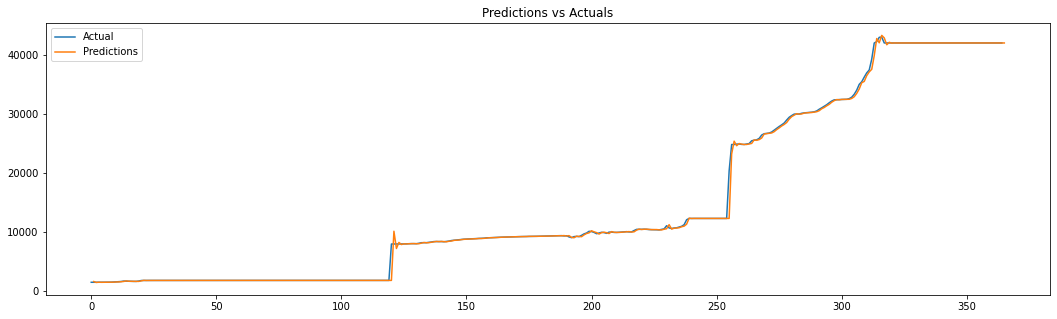


==================================================Residuals====================================================================================================



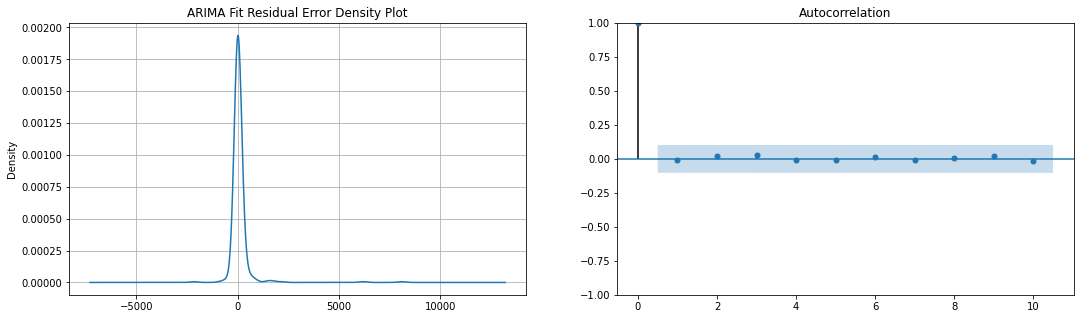

Mean: 85.94037877125592
STD: 587.7204262269355

Ljung-Box Test
p-values: [0.84085358 0.87920348 0.91615684 0.96718227 0.98864268 0.99520287
 0.99848323 0.99952878 0.99975153 0.99987775]
result: Independent




In [ ]:
show_model_diagnostics(exchange_rate_df["USD"], exchange_rate_model, forecasts=1)

Now let's see the foracasts this model makes.

In [ ]:
exchange_rate_df.tail(3)

,date,USD
362,03/01/1401,42000.0
363,04/01/1401,42000.0
364,05/01/1401,42000.0


In [ ]:
print(f"The USD forecast for 06/01/1401 is: {exchange_rate_model.forecast().to_numpy()[0]}")

The USD forecast for 06/01/1401 is: 42000.0


## Monthly CPI Analysis

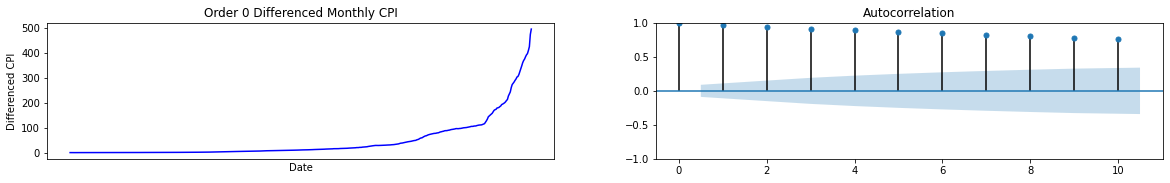

Std of the differenced series: 82.41550365433584
ADF Statistic: 2.7203236846906558
p-value: 0.9990878208577344
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570
Non-stationary




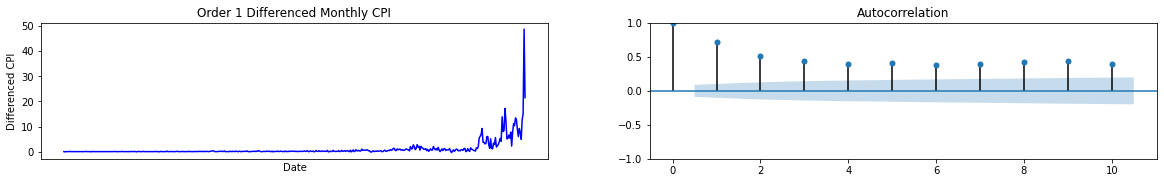

Std of the differenced series: 3.278409375744629
ADF Statistic: 7.845916630427532
p-value: 1.0
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570
Non-stationary




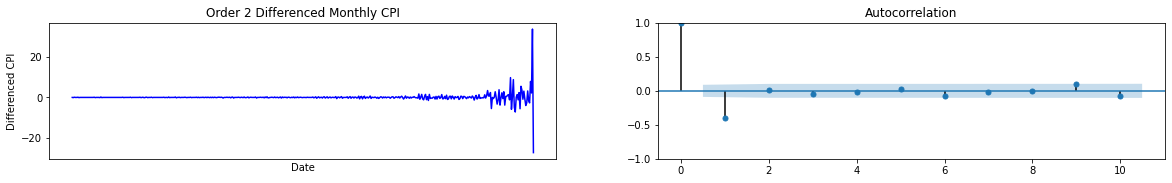

Std of the differenced series: 2.299719232780586
ADF Statistic: -7.8062371877579295
p-value: 7.269059416395962e-12
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570
Stationary


The dataset is staionary with differencing order 2.


In [ ]:
check_stationarity(
    monthly_cpi_df["monthly CPI"],
    monthly_cpi_df["date"],
    "Monthly CPI",
    "CPI",
    "Date",
)

From the stationarity check, the choice of d=2 might be good although a little over-differenced. Let's plot the ACF and PACF to get some insight.

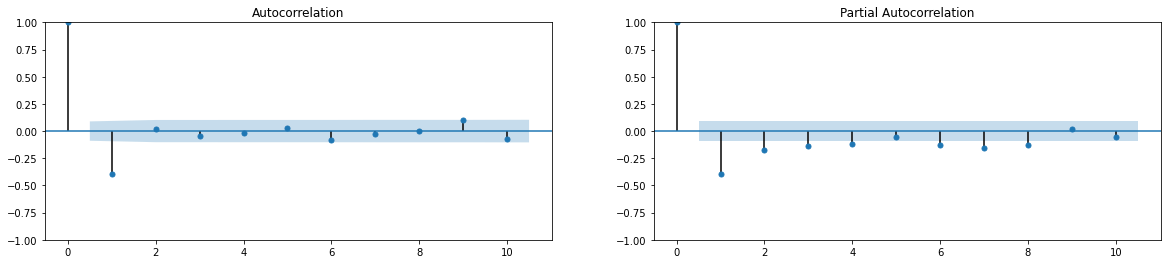

In [ ]:
plot_acf_pacf(apply_diff(monthly_cpi_df["monthly CPI"], d=2), lags=10)

According to the plots above, the choice of q=1 or 6 or 9 seems proper. But for the p parameter, we might choose numbers 1 to 3 or 7. Before that, let's take a look at the auto_arima models' selection.

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2176.655, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2058.106, Time=0.37 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=2059.516, Time=0.65 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=2045.752, Time=0.57 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=2068.156, Time=1.01 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=2028.095, Time=1.87 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2056.200, Time=0.20 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2057.998, Time=0.62 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=2058.535, Time=0.86 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2047.496, Time=1.08 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=2061.059, Time=2.29 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2058.076, Time=0.28 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2049.836, Time=0.55 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=2049.201, Time=0.59 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=2049.376, Time=0.87 sec
 ARIMA(3,2

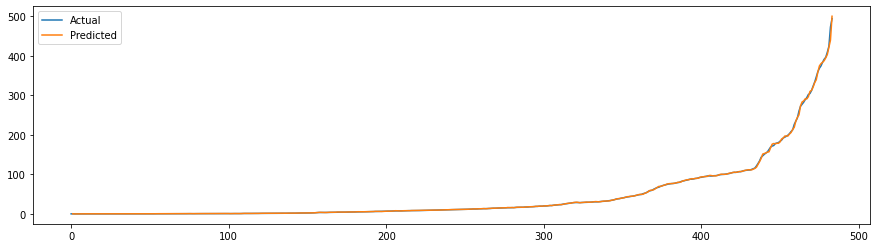

In [ ]:
apply_auto_arima_model_selection(monthly_cpi_df["monthly CPI"], stepwise=False)

So we will test for (0, 2, 5) model as well since it had the least AIC in the models auto_arima tested. Now its time to provide the list of out guesses for a good model and select the best of them based on both the AIC score and MAE measure.

In [ ]:
check_models(
    monthly_cpi_df["monthly CPI"],
    [
        (0, 2, 5),
        (1, 2, 1), (2, 2, 1), (3, 2, 1),
        (1, 2, 6), (2, 2, 6), (3, 2, 6),
        (1, 2, 9), (2, 2, 9), (3, 2, 9),
        (7, 2, 6), (7, 2, 9)
    ],
)

ARIMA(0, 2, 5)			:AIC=2028.378, BIC=2053.446, MAE=0.555
ARIMA(1, 2, 1)			:AIC=2057.247, BIC=2069.781, MAE=0.523
ARIMA(2, 2, 1)			:AIC=2050.145, BIC=2066.857, MAE=0.494
ARIMA(3, 2, 1)			:AIC=2047.015, BIC=2067.905, MAE=0.512
ARIMA(1, 2, 6)			:AIC=2020.354, BIC=2053.778, MAE=0.575
ARIMA(2, 2, 6)			:AIC=1981.452, BIC=2019.054, MAE=0.577
ARIMA(3, 2, 6)			:AIC=1985.164, BIC=2026.943, MAE=0.636
ARIMA(1, 2, 9)			:AIC=1923.896, BIC=1969.854, MAE=0.653
ARIMA(2, 2, 9)			:AIC=1920.096, BIC=1970.232, MAE=0.627
ARIMA(3, 2, 9)			:AIC=1919.422, BIC=1973.735, MAE=0.61
ARIMA(7, 2, 6)			:AIC=1913.657, BIC=1972.148, MAE=0.571
ARIMA(7, 2, 9)			:AIC=1878.263, BIC=1949.288, MAE=0.541


As you see, the (7, 2, 9) show a noticably smaller AIC/BIC score compared to the auto arima output as well as a smaller MAE. So we will choose this model for monthly cpi.

In [ ]:
monthly_cpi_model = ARIMA(monthly_cpi_df["monthly CPI"], order=(7, 2, 9)).fit()

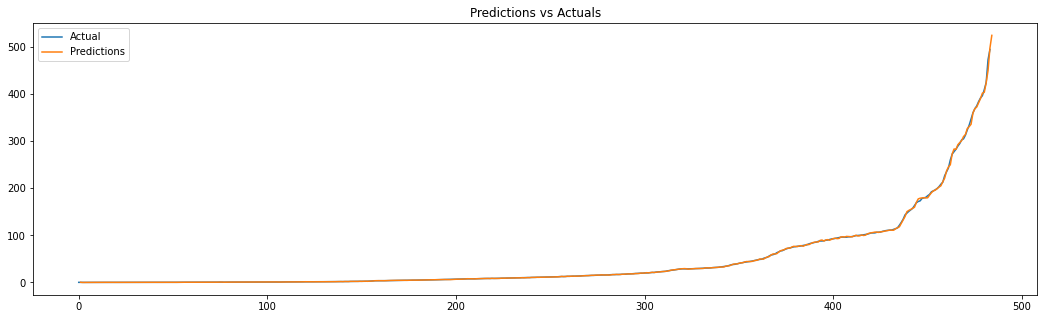


==================================================Residuals====================================================================================================



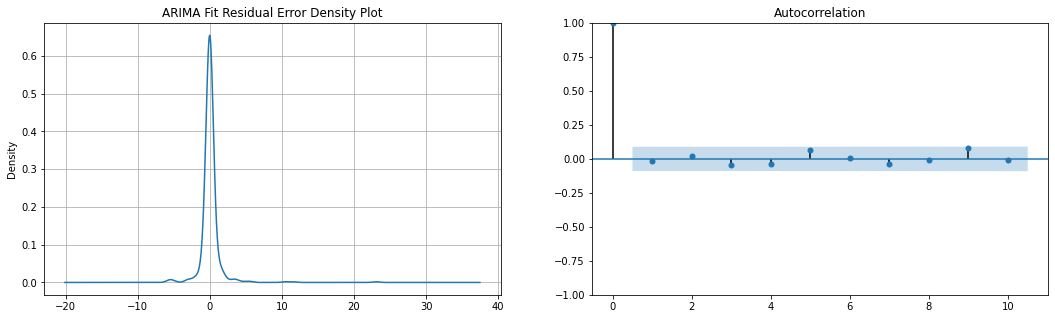

Mean: 0.09433459401259683
STD: 1.5927834531128828

Ljung-Box Test
p-values: [0.71667423 0.86596279 0.76608571 0.78869543 0.57582962 0.69713738
 0.72872298 0.80989294 0.54479429 0.6340681 ]
result: Independent




In [ ]:
show_model_diagnostics(monthly_cpi_df["monthly CPI"], monthly_cpi_model, forecasts=1)

Now let's see the foracasts this model makes.

In [ ]:
monthly_cpi_df.tail(3)

,date,monthly CPI
481,2/1/1401,424.4
482,3/1/1401,473.2
483,4/1/1401,494.7


In [ ]:
print(f"The CPI forecast for 5/1/1401 is: {monthly_cpi_model.forecast().to_numpy()[0]}")

The CPI forecast for 5/1/1401 is: 524.6622325597888


## Annual CPI Analysis

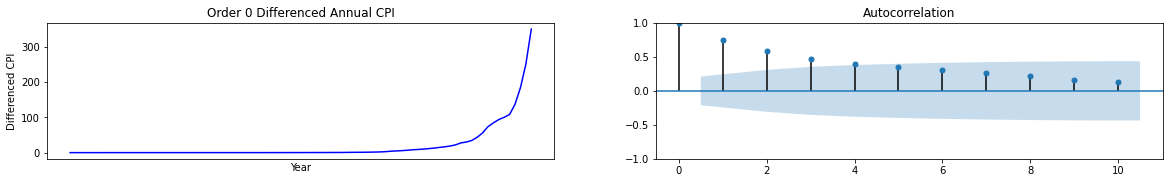

Std of the differenced series: 54.549575928522934
ADF Statistic: 4.661678164454868
p-value: 1.0
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Non-stationary




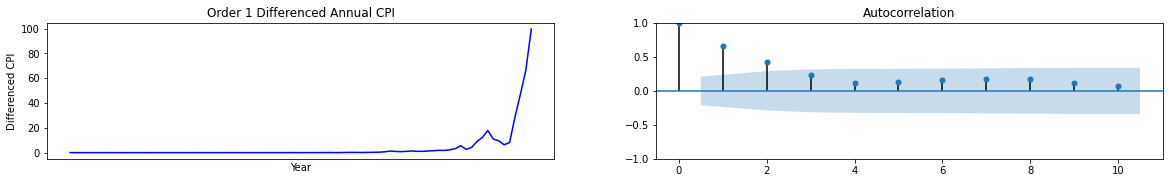

Std of the differenced series: 14.027271467353241
ADF Statistic: 4.854585906137512
p-value: 1.0
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Non-stationary




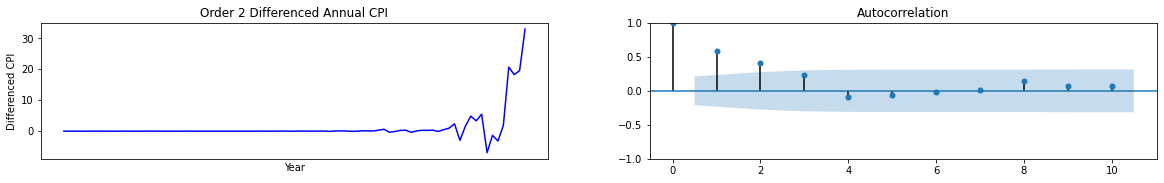

Std of the differenced series: 5.126546814049138
ADF Statistic: 6.0139057950029615
p-value: 1.0
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Non-stationary




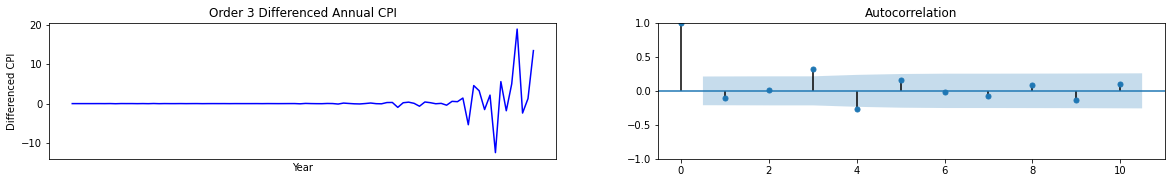

Std of the differenced series: 3.0785117316705994
ADF Statistic: 5.535943495572009
p-value: 1.0
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Non-stationary




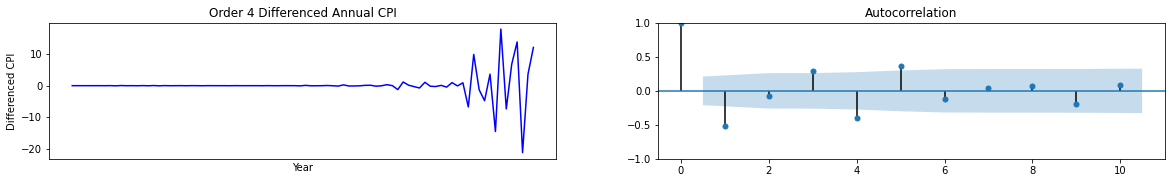

Std of the differenced series: 4.350430981230005
ADF Statistic: -1.9728040848276367
p-value: 0.2986233648537183
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Non-stationary




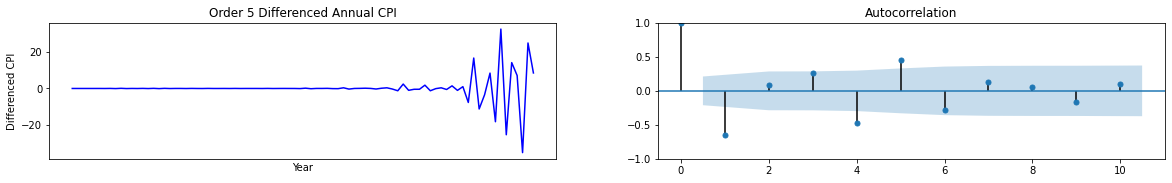

Std of the differenced series: 7.450265263618833
ADF Statistic: -8.287295444271155
p-value: 4.3558894682023333e-13
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588
Stationary


The dataset is staionary with differencing order 5.


In [ ]:
check_stationarity(
    annual_cpi_df["annual CPI"],
    annual_cpi_df["year"],
    "Annual CPI",
    "CPI",
    "Year",
)

As you see, d=2 seems the first good choice for d since the ACF drops to 0 quite fast. d=3 also seems good because the std is smaller and the ACF are not even close to the negative bounds of over-differencing (-0.5).

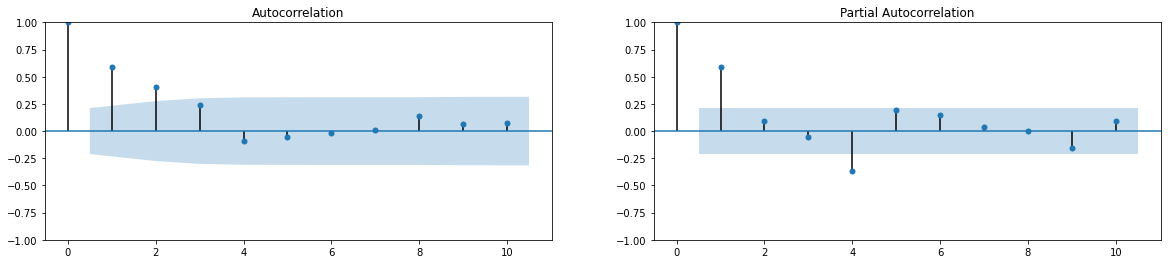

In [ ]:
plot_acf_pacf(apply_diff(annual_cpi_df["annual CPI"], d=2), lags=10)

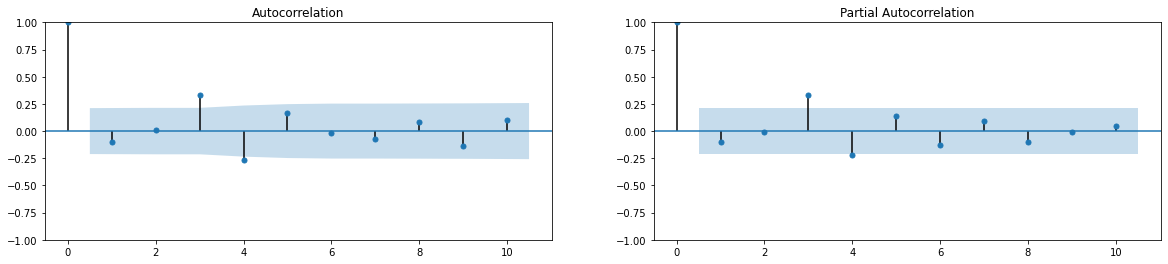

In [ ]:
plot_acf_pacf(apply_diff(annual_cpi_df["annual CPI"], d=3), lags=10)

For d=2, a choice of q=1 or 2 and p=1 or 4 seems good. And for d=3, a choice of q=3 or 4 and p=3 or 4 seems good. We'll test them very soon but before that let's appy the auto arima model selection as well.

 ARIMA(0,4,0)(0,0,0)[0]             : AIC=479.842, Time=0.02 sec
 ARIMA(0,4,1)(0,0,0)[0]             : AIC=427.506, Time=0.04 sec
 ARIMA(0,4,2)(0,0,0)[0]             : AIC=425.668, Time=0.05 sec
 ARIMA(0,4,3)(0,0,0)[0]             : AIC=427.541, Time=0.08 sec
 ARIMA(0,4,4)(0,0,0)[0]             : AIC=419.596, Time=0.35 sec
 ARIMA(0,4,5)(0,0,0)[0]             : AIC=405.940, Time=0.75 sec
 ARIMA(1,4,0)(0,0,0)[0]             : AIC=454.544, Time=0.03 sec
 ARIMA(1,4,1)(0,0,0)[0]             : AIC=426.413, Time=0.15 sec
 ARIMA(1,4,2)(0,0,0)[0]             : AIC=424.207, Time=0.12 sec
 ARIMA(1,4,3)(0,0,0)[0]             : AIC=417.796, Time=0.11 sec
 ARIMA(1,4,4)(0,0,0)[0]             : AIC=417.705, Time=0.38 sec
 ARIMA(2,4,0)(0,0,0)[0]             : AIC=423.208, Time=0.11 sec
 ARIMA(2,4,1)(0,0,0)[0]             : AIC=420.240, Time=0.14 sec
 ARIMA(2,4,2)(0,0,0)[0]             : AIC=413.688, Time=0.25 sec
 ARIMA(2,4,3)(0,0,0)[0]             : AIC=411.621, Time=0.68 sec
 ARIMA(3,4,0)(0,0,0)[0]  

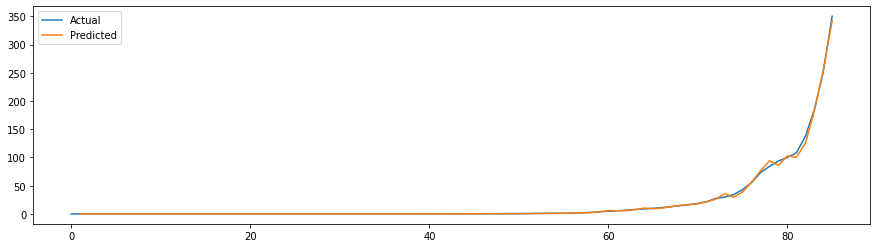

In [ ]:
apply_auto_arima_model_selection(annual_cpi_df["annual CPI"], stepwise=False)

So we will test for (5, 4, 0) model as well since it had the least AIC in the models auto_arima tested. Now its time to provide the list of out guesses for a good model and select the best of them based on both the AIC score and MAE measure.

In [ ]:
check_models(
    annual_cpi_df["annual CPI"],
    [
        (5, 4, 0),
        (1, 2, 1), (1, 2, 2), (4, 2, 1), (4, 2, 2),
        (3, 3, 3), (3, 2, 4), (4, 2, 3), (4, 2, 4),
    ],
)

ARIMA(5, 4, 0)			:AIC=405.475, BIC=419.916, MAE=0.97
ARIMA(1, 2, 1)			:AIC=439.64, BIC=446.933, MAE=0.944
ARIMA(1, 2, 2)			:AIC=436.16, BIC=445.883, MAE=1.127
ARIMA(4, 2, 1)			:AIC=420.978, BIC=435.563, MAE=0.973
ARIMA(4, 2, 2)			:AIC=419.83, BIC=436.846, MAE=0.945
ARIMA(3, 3, 3)			:AIC=408.753, BIC=425.685, MAE=0.985
ARIMA(3, 2, 4)			:AIC=415.111, BIC=434.557, MAE=0.949
ARIMA(4, 2, 3)			:AIC=417.306, BIC=436.753, MAE=0.995
ARIMA(4, 2, 4)			:AIC=417.711, BIC=439.588, MAE=0.963


As you see, the (3, 3, 3) model has the second smallest AIC but also has a smaller MAE compared to the model with least AIC. Also the differencing order of this model is smaller which implies a less naive forecast. So we will choose this model for the annual cpi.

In [ ]:
annual_cpi_model = ARIMA(annual_cpi_df["annual CPI"], order=(3, 3, 3)).fit()

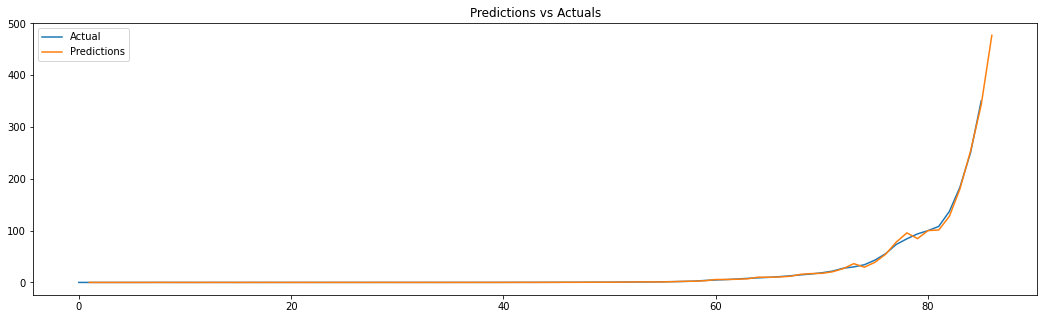


==================================================Residuals====================================================================================================



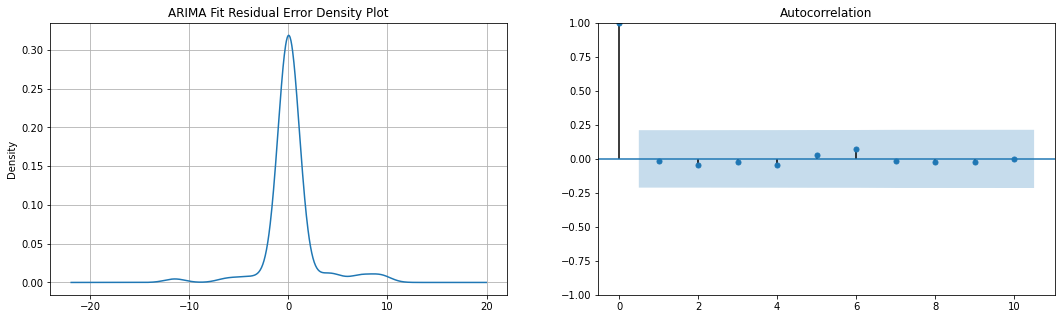

Mean: 0.2729624668934974
STD: 2.4975323260451385

Ljung-Box Test
p-values: [0.88132114 0.895546   0.9632513  0.97521326 0.98931683 0.98082403
 0.99206885 0.99665353 0.99867071 0.99954547]
result: Independent




In [ ]:
show_model_diagnostics(annual_cpi_df["annual CPI"], annual_cpi_model, forecasts=1)

Now let's see the foracasts this model makes.

In [ ]:
annual_cpi_df.tail(3)

,year,annual CPI
83,1398,183.9958
84,1399,250.6023
85,1400,350.1596


In [ ]:
print(f"The CPI forecast for 1401 is: {annual_cpi_model.forecast().to_numpy()[0]}")

The CPI forecast for 1401 is: 476.77463126953234
